**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$

To make understanding easier, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  #将一个方程分割为了实部和虚部两个部分

$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where $\mathrm{u}(x,t)$ and $\mathrm{v}(x,t)$ denote respectively the real and the imaginary part of h.  

Step 1: Setup

In [49]:
import sys
sys.path.append('H:/毕业论文/pykan')
sys.path.append('H:/毕业论文/efficient-kan/src')
from scipy.interpolate import griddata
from efficient_kan import KAN as EKAN
from kan import KAN, LBFGS
from kan import LBFGS
import torch
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Gradient-Cacl.  梯度批量计算
def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


Step 2:

In this Part, according to the problem, we need to construct the specific PDE.

In [50]:
#geom number_points bigger → better
geom = [-5.0,5.0]
num_points_x = 256

#time domain number_points越大越好
TimeDomain = [0,np.pi/2]
num_points_t = 201


# Creation of the 2D domain (for plotting and input)
# 创造一个2D区域作为输入和帮助画图
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

t = torch.linspace(TimeDomain[0],TimeDomain[1],
                   steps=num_points_t, device=device,
                   requires_grad=False)
X,T = torch.meshgrid(x, t, indexing='ij')  #生成网格

coordinates = torch.stack([X.flatten(), T.flatten()], dim = 1).to(device)
print(coordinates)  #归一化处理
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度


##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

tensor([[-5.0000,  0.0000],
        [-5.0000,  0.0079],
        [-5.0000,  0.0157],
        ...,
        [ 5.0000,  1.5551],
        [ 5.0000,  1.5629],
        [ 5.0000,  1.5708]], device='cuda:0')


Step 3: KAN

In [51]:
#注意到我们其实需要的是 两个输入x和t 两个输出真解u,v 的KAN神经网络
layer = [2] + [3]*2 + [2]   #[input] + [nn]*hiden + [output] 

#oringinal KAN
# model = KAN(width=layer, grid=3, k=3, grid_eps=1,
#             noise_scale_base=0.25,device = device)

# ##efficient - KAN
model = EKAN(layer,grid_size=3,spline_order=3,
            scale_noise=0.1,grid_eps=1.0,base_activation=nn.Identity).to(device)  
# # #Efficient-KAN 的设备指定.to(device)

由于边界条件：

$$x \in [-5,5], \quad t \in [0, \pi/2]$$ 
$$h(t, -5) = h(t,5)~~~~~~h(t, -5) - h(t,5) = 0$$ 
$$h_x(t, -5) = h_x(t,5)~~~~~~h_x(t, -5) - h_x(t,5) = 0$$  

$$\mathrm{MSE_{BC}}(u_{pred},0)$$

由于初始条件：

$$\quad h(0,x) = 2 sech(x), ~~~~~\mathrm{MSE_{IC}}(u_{pred}, 2 sech(x))$$



In [52]:
def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    u = model(coords)[:, 0]  #predicted solution
    v = model(coords)[:, 1]
    
    #coords[X,T]  [:, :, :]  前两个指的的真解u 后一个指的是对应的x和t x：0  t：1
    u_t = grads[:,0,1]  #d_u/dt
    v_t = grads[:,1,1]  #d_v/dt

    u_xx = hessians[:,0, 0]  #d^2_u/dx^2
    v_xx = hessians[:,1, 0]

    #residuals of PDE：PDE的残差
    equation_1 = u_t + 1/2 * v_xx + (u**2 + v**2) * v
    equation_2 = v_t - 1/2 * u_xx - (u**2 + v**2) * u 
    loss_pde = torch.mean(equation_1 **2) + torch.mean(equation_2 **2)


    #BC and IC: 找到位于边界和初始上的点
    BC_mask_left = (coords[:, 0] == geom[0])  #边界点下标
    BC_mask_righ = (coords[:, 0] == geom[1])

    BC_left = coords[BC_mask_left]  #h(-5,t) 201×2
    BC_righ = coords[BC_mask_righ]  #h(5,t)  201x2  total 256x2
    # print("BC_left",BC_left,BC_left.shape)

    bc_u_left = model(BC_left)[:,0]
    bc_v_left = model(BC_left)[:,1]
    bc_u_righ = model(BC_righ)[:,0]
    bc_v_righ = model(BC_righ)[:,1]
    loss_h = torch.mean((bc_u_left-bc_u_righ)**2) + torch.mean((bc_v_left-bc_v_righ)**2)

    bc_ux_left = batch_jacobian(model,BC_left,create_graph=True)[:,0,0]
    bc_vx_left = batch_jacobian(model,BC_left,create_graph=True)[:,1,0]
    bc_ux_righ = batch_jacobian(model,BC_righ,create_graph=True)[:,0,0]  #得到位于边界的 dh_x
    bc_vx_righ = batch_jacobian(model,BC_righ,create_graph=True)[:,1,0]
    # bc_dh = bc_ux_left + bc_vx_left - bc_ux_righ - bc_vx_righ
    loss_dh = torch.mean((bc_ux_left-bc_ux_righ)**2) + torch.mean((bc_vx_left-bc_vx_righ)**2)

    #IC:初始条件  u初始为："2 sech(x)"   v：为0
    IC_mask = (coords[:, 1] == TimeDomain[0])
    IC_points = coords[IC_mask][:,0].unsqueeze(1)
    model_ic = model(coords[IC_mask])  #u[:,0]  v[:,1]
    true_ic = 2 / torch.cosh(IC_points)
    # print("ic:",model_ic[:,0].unsqueeze(1).shape)
    # print("true ic: ",true_ic.shape)
    loss_ic = torch.mean((model_ic[:,0] - true_ic)**2) #+ torch.mean(model_ic[:,1]) **2)

    total_loss = loss_pde + loss_ic + loss_h + loss_dh
    # BC_points_left = coords[BC_mask_left][:,0].unsqueeze(1)
    # BC_points_righ = coords[BC_mask_righ][:,0].unsqueeze(1)
 


    # print("IC_X:",IC_points,IC_points.shape)

    # print("BC_POINT",coords[BC_mask],coords[BC_mask].shape)
    # print("IC_POINT",coords[IC_mask],coords[IC_mask].shape)

    ##BC:边界条件
    # model_bc = model(coords[BC_mask])  #coords[BC_mask][X:T] X:-1.0 and 1.0  T:uniform[0,1]  [200 x 2]
    # bc_loss = torch.mean(model_bc**2)

    # ##IC:初始条件
    # model_ic = model(coords[IC_mask])  #coords[IC_mask][X:T] X:uniform[-,1]  T:0  [200 x 2]
    # true_ic = -torch.sin(np.pi * IC_points)
    # ic_loss = torch.mean((model_ic - true_ic)**2)  #Only ic need a minus-form
    #print("BC:", bc_loss)
    #print("IC:", ic_loss)
    #print("PDE:", pde_loss)
    # total_loss = pde_loss + ic_loss + bc_loss
    # print(loss_pde,loss_ic,loss_h,loss_dh)
    return total_loss

Step: 4 | Loss: 0.414: 100%|██████████| 5/5 [00:31<00:00,  6.26s/it]

[0.7329680323600769, 0.4610555171966553, 0.42861902713775635, 0.41718560457229614, 0.41387009620666504]


Text(0.5, 1.0, 'Loss of KAN')

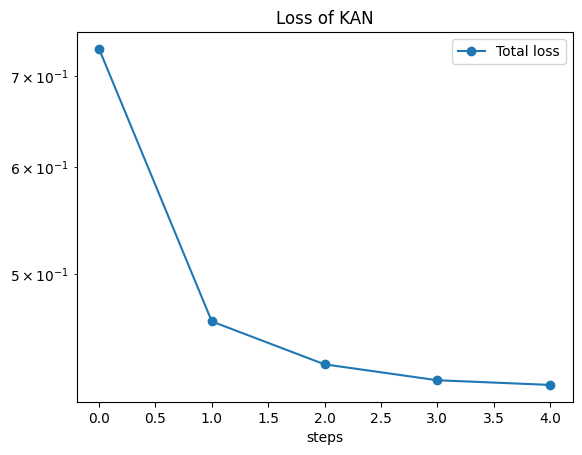

In [53]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    # optimizer = optim.LBFGS(model.parameters(), lr=1e-1,
    #                   history_size=10, line_search_fn="strong_wolfe")
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    optimizer = LBFGS(model.parameters(), lr=1e-2,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    
    steps = 5 # 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

[[ 0.5888902  -0.03498087]
 [ 0.5886692  -0.03348751]
 [ 0.58844787 -0.0319937 ]
 ...
 [ 0.53381324  0.2604145 ]
 [ 0.53352475  0.2618641 ]
 [ 0.53323615  0.26331434]] (51456, 2)
u: [[0.58889019 0.58866918 0.58844787 ... 0.54042047 0.540151   0.53988117]
 [0.58851784 0.58829516 0.58807224 ... 0.53981513 0.53954536 0.53927535]
 [0.58811992 0.58789557 0.58767098 ... 0.5392049  0.53893518 0.538665  ]
 ...
 [0.59142119 0.59113181 0.59084231 ... 0.5342887  0.53400087 0.53371292]
 [0.59123689 0.59094751 0.59065795 ... 0.53404689 0.53375876 0.53347051]
 [0.59106272 0.59077322 0.59048361 ... 0.53381324 0.53352475 0.53323615]] (256, 201) 
 v: [[-0.03498087 -0.03348751 -0.0319937  ...  0.26103276  0.2625514
   0.26407206]
 [-0.03429281 -0.03279885 -0.03130418 ...  0.26172644  0.26324442
   0.26476395]
 [-0.03358298 -0.03208824 -0.03059279 ...  0.26243469  0.26395106
   0.26546976]
 ...
 [-0.03890116 -0.03731868 -0.03573642 ...  0.25873357  0.26018071
   0.26162913]
 [-0.0382431  -0.03666065 -0.0

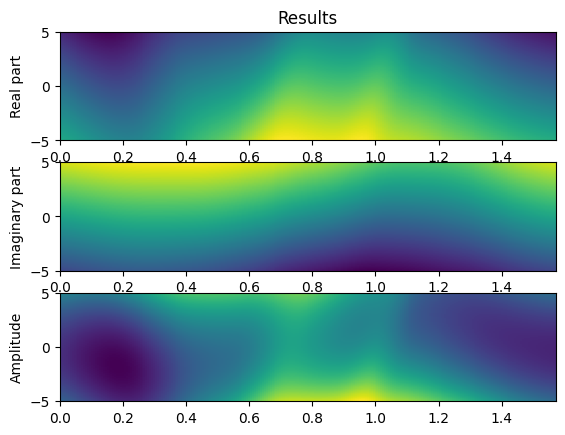

In [54]:
# Make prediction
prediction = model(coordinates) #.data.numpy().cpu()
prediction = prediction.data.cpu().numpy()

print(prediction,prediction.shape)
coordinates = coordinates.data.cpu().numpy()
X= X.data.cpu().numpy()
T= T.data.cpu().numpy()
u = griddata(coordinates, prediction[:, 0], (X, T), method="cubic")
v = griddata(coordinates, prediction[:, 1], (X, T), method="cubic")
h = np.sqrt(u ** 2 + v ** 2)

print("u:",u,u.shape,"\n","v:",v,v.shape)
print("h:",h,h.shape)
# Plot predictions
fig, ax = plt.subplots(3)
ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[TimeDomain[0], TimeDomain[1], geom[0], geom[1]],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[TimeDomain[0], TimeDomain[1], geom[0], geom[1]],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[TimeDomain[0], TimeDomain[1], geom[0], geom[1]],
    origin="lower",
    aspect="auto",
)

plt.show()